In [6]:
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.io as sio
from scipy.interpolate import interp1d
import math
from scipy import stats
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.decomposition import PCA

import shutil
import os
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 4),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Load data and setup

In [2]:
from analysis_functions import *
from plotting_functions import *

### Define parameters

In [3]:
monkey = 'Stanton'

save_figs = True

########### Analysis parameters ###########

# BINNING/SMOOTHING PARAMETERS
bins = np.arange(-500, 3051)
sm_std = 30 # gaussian smoothing stdev
bin_size = 100 # msec for binend data

# rCTI
step_size = 10 # step size for sliding window ROC analysis (in ms)

# DECODING
# Number iterations
n_iter = 200

# Num trials
n_trials_cat = 20 # per dir, so per cat = 60
n_trials_dir = 12 # per dir

# Equal number of neurons per area
count_matched = True

In [5]:
# PATHS
figpath = 'E:\\two_boundary\\figures\\'
datapathsave = 'E:\\two_boundary\\data\\'

brain_areas = ['MT', 'MST', 'LIP', 'SC']
#brain_areas = ['MT', 'MST', 'LIP']

# Get number of neurons per area
n_neurons = {}
for area in brain_areas:
    datadir = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
    os.chdir(datadir)
    n_neurons[area] = len([f for f in glob.glob("*.mat")])
    
# bins for rCTI and decoder plotting
bins_rCTI = np.arange(bins[0], bins[-1], step_size)
bins_decoder = np.arange(bins[0], bins[-1], step_size)

# rCTI direction pairs
DIRS = np.array(DIRS)
BCD_pairs = [[22.5, 157.5], [247.5, 112.5], [202.5, 337.5], [67.5, 292.5]]
BCD_pairs_indx = [[np.where(DIRS == i[0])[0][0], np.where(DIRS == i[1])[0][0]] for i in BCD_pairs]

WCD_pairs = [[337.5, 112.5], [157.5, 292.5], [67.5, 202.5], [247.5, 22.5]]
WCD_pairs_indx = [[np.where(DIRS == i[0])[0][0], np.where(DIRS == i[1])[0][0]] for i in WCD_pairs]


# Variance alignment

In [5]:
n_dims = 12

indx1 = 150
indx2 = 250

n_rand = 10000


In [8]:
sample_timepoints = np.arange(np.where(bins == indx1)[0][0], np.where(bins == indx2)[0][0])
test_timepoints = np.arange(np.where(bins == DELAY1+indx1)[0][0], np.where(bins == DELAY1+indx2)[0][0])

all_variances = {}

for area in brain_areas:
    
    all_variances[area] = {}
    
    if monkey != 'both':
        currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]

    else:
        currpath1 = datapathsave + 'Neville' + '\\' + area + '\\good_neurons\\task_responsive\\'   
        currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\good_neurons\\task_responsive\\'
      
        os.chdir(currpath1)
        filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        os.chdir(currpath2)
        filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        
        filelist = np.hstack([filelist1, filelist2])
        
    spikes_all = []

    for file in filelist:
        data = sio.loadmat(file)
        data_by_cond = data['binned_spikes'].flatten()*10
        data_by_dir = org_data_by_dir(data_by_cond)
        stacked_sample = np.hstack([gaussian_filter1d(np.mean(data_by_dir[i][:, sample_timepoints], 0), sm_std) for i in CENTER_DIRS])       
        
        data_by_test = org_data_by_test(data_by_cond)
        stacked_test = np.hstack([gaussian_filter1d(np.mean(i[:, test_timepoints], 0), sm_std) for i in data_by_test[0]])   
        
        #stacked_sample = np.hstack([gaussian_filter1d(np.mean(data_by_test[1][i][:, test_timepoints], 0), 30) for i in range(0, 8, 2)])  
        #stacked_test = np.hstack([gaussian_filter1d(np.mean(data_by_test[1][i][:, test_timepoints], 0), 30) for i in range(1, 8, 2)])   
        
        stacked = np.hstack([stacked_sample, stacked_test])
        spikes_all.append(stacked.T)
        
    all_stacked = np.array(spikes_all).T    

    pca = PCA(n_components = len(filelist))
    pca.fit(all_stacked)

    projection = pca.transform(all_stacked)

    #n_timepoints = len(timepoints)

    #pca_indices = {}

    #for i_dir in range(N_DIRS):
        #startindx = 0+(n_timepoints*i_dir)
        #pca_indices[i_dir] = [startindx, startindx+n_timepoints]        
        
    new_data = projection[:, 0:n_dims]
    samp = new_data[0:len(sample_timepoints)*4]
    test = new_data[len(sample_timepoints)*4:]
    
    sp.io.savemat('E:\\two_boundary\\' + area + '.mat', {'samp': samp, 'test': test})    

    pca = PCA(n_components = n_dims)
    pca.fit(samp)
    projection = pca.transform(test)
    
    vars_proj = [np.var(projection[:, i]) for i in range(n_dims)]
    all_variances[area]['samp_test'] = vars_proj

    pca.fit(test)
    all_variances[area]['test_test'] = pca.explained_variance_
    

    random_vals = np.zeros([n_rand, n_dims])
    C = np.cov(test.T)

    for i_rand in range(n_rand):
        coeffRand = sp.linalg.orth(np.random.rand(n_dims, n_dims))
        random_vals[i_rand] = np.diag(coeffRand.T @ C @ coeffRand)
        
    all_variances[area]['random'] = random_vals
    
    

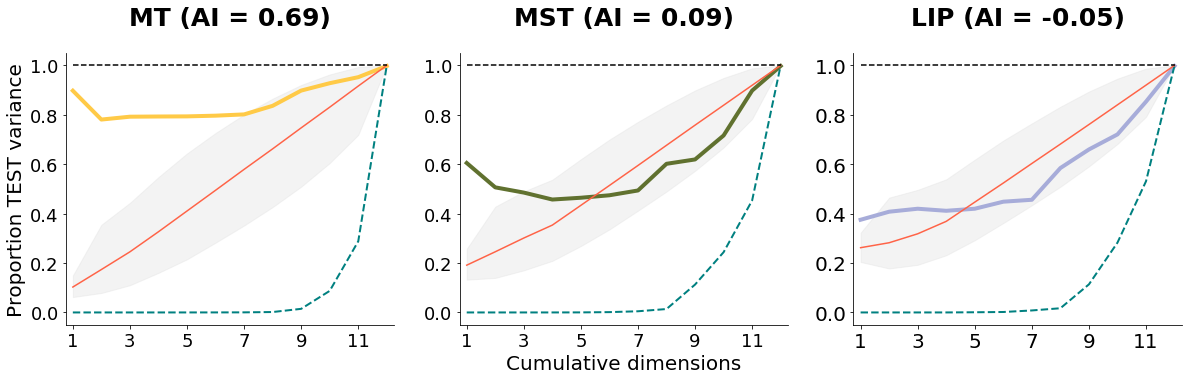

In [10]:
fig, ax =  plt.subplots(1, 3, figsize=(20, 5))
    
for i, area in enumerate(brain_areas):
    
    data_line =  np.cumsum(all_variances[area]['samp_test'])/np.cumsum(all_variances[area]['test_test'])
    rand_line = np.cumsum(np.mean(all_variances[area]['random'], 0))/np.cumsum(all_variances[area]['test_test'])
    randCum = np.vstack([np.cumsum(row) for row in all_variances[area]['random']])
    randCI = np.quantile(randCum, [0.025, 0.975], 0)/np.cumsum(all_variances[area]['test_test'])
    misalign = np.cumsum(list(reversed(all_variances[area]['test_test'])))/np.cumsum(all_variances[area]['test_test'])
    
    raw_val = sum(data_line-rand_line)
    if raw_val > 0:
        align_indx = raw_val/sum(1-rand_line)
    else:
        align_indx = raw_val/sum(rand_line - misalign)

    
    #tmp = all_variances[area]['samp_test']/all_variances[area]['test_test']
    ax[i].plot(range(1, n_dims+1),data_line, color = plot_colors[area], lw = 4)
    ax[i].plot(range(1, n_dims+1), misalign, '--', color = 'teal', label = 'Maximally misaligned', lw = 2)
    ax[i].plot(range(1, n_dims+1), rand_line, color = 'tomato', label = 'Random')
    ax[i].plot(range(1, n_dims+1), np.ones(n_dims), '--', color = 'k', label = 'Perfect alignment')
    ax[i].fill_between(range(1, n_dims+1), randCI[0], randCI[1], color = 'lightgrey', lw = 1., alpha = 0.25)
    #ax[i].plot(range(1, n_dims+1), np.cumsum(all_variances[area]['samp_test']), color = plot_colors[area], label = area, lw = 2)

    ax[i].set_xlim(0.75, n_dims + 0.25)
    ax[i].set_xticks(np.arange(1, n_dims+1, 2))
    #ax[i].legend(frameon = False, fontsize = 20)
    #plt.ylim(0, 1.1)
    ax[i].set_title(area + ' (AI = {:.2f})'.format(align_indx), fontsize = 25, y = 1.08, fontweight='bold')

    ax[i].tick_params(labelsize = 18)

    # Hide the right and top spines
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    plt.tick_params(labelsize=20)
    
ax[1].set_xlabel('Cumulative dimensions', fontsize = 20)
ax[0].set_ylabel('Proportion TEST variance', fontsize = 20)

for i in save_filetype:
    savepath = figpath + 'pca\\' + monkey + '_variance_alignment_dmc_samp_test_150_250.' + i
    fig.savefig(savepath, bbox_inches='tight')
 

In [994]:
align_indx

array([-5.31887483e+00, -3.79754210e+00, -2.78596532e+00, -2.22710215e+00,
       -1.85291278e+00, -1.59716269e+00, -1.40946255e+00, -1.26722358e+00,
       -1.16986580e+00, -1.11001259e+00, -1.27589158e+00, -1.03056086e+15])

### All timepoints

In [708]:
monkey = 'both'
n_dims = 12

(8, 8)

In [ ]:
from sklearn.decomposition import PCA

timepoints = np.arange(np.where(bins == -100)[0][0], np.where(bins == TEST1)[0][0])

all_variances = {}

for area in brain_areas:
    
    all_variances[area] = {}
    
    if monkey != 'both':
        currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'
        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]

    else:
        currpath1 = datapathsave + 'Neville' + '\\' + area + '\\good_neurons\\task_responsive\\'   
        currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\good_neurons\\task_responsive\\'
      
        os.chdir(currpath1)
        filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        os.chdir(currpath2)
        filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        
        filelist = np.hstack([filelist1, filelist2])
        
    spikes_all = []

    for file in filelist:
        data = sio.loadmat(file)
        data_by_cond = data['binned_spikes'].flatten()*10
        data_by_dir = org_data_by_dir(data_by_cond)
        stacked = np.hstack([gaussian_filter1d(np.mean(i[:, timepoints], 0), 30) for i in data_by_dir])       
        spikes_all.append(stacked.T)
        
        
    all_stacked = np.array(spikes_all).T    

    pca = PCA(n_components = len(filelist))
    pca.fit(all_stacked)

    projection = pca.transform(all_stacked)

    n_timepoints = len(timepoints)

    pca_indices = {}

    for i_dir in range(N_DIRS):
        startindx = 0+(n_timepoints*i_dir)
        pca_indices[i_dir] = [startindx, startindx+n_timepoints]        
        
    new_data = projection[:, 0:n_dims]
    samp = []
    test = []

    for i in range(0, 12):
        samp.append(new_data[0*i+300:0*i+400])
        test.append(new_data[0*i+400:500+0*i])
        
    samp = np.vstack(samp)
    test = np.vstack(test)
    
    sp.io.savemat('E:\\two_boundary\\' + area + '.mat', {'samp': samp, 'test': test})    

    pca = PCA(n_components = n_dims)
    pca.fit(samp)
    projection = pca.transform(test)
    
    vars_proj = [np.var(projection[:, i]) for i in range(n_dims)]
    all_variances[area]['samp_test'] = vars_proj

    pca.fit(test)
    all_variances[area]['test_test'] = pca.explained_variance_
    
    n_rand = 10000

    random_vals = np.zeros([n_rand, n_dims])
    C = np.cov(test.T)

    for i_rand in range(n_rand):
        coeffRand = sp.linalg.orth(np.random.rand(n_dims, n_dims))
        random_vals[i_rand] = np.diag(coeffRand.T @ C @ coeffRand)
        
    all_variances[area]['random'] = random_vals
    
    

In [ ]:
fig, ax =  plt.subplots(1, 3, figsize=(20, 5))
    
for i, area in enumerate(brain_areas):
    
    data_line =  np.cumsum(all_variances[area]['samp_test'])/np.cumsum(all_variances[area]['test_test'])
    rand_line = np.cumsum(np.mean(all_variances[area]['random'], 0))/np.cumsum(all_variances[area]['test_test'])
    randCum = np.vstack([np.cumsum(row) for row in all_variances[area]['random']])
    randCI = np.quantile(randCum, [0.025, 0.975], 0)/np.cumsum(all_variances[area]['test_test'])
    misalign = np.cumsum(list(reversed(all_variances[area]['test_test'])))/np.cumsum(all_variances[area]['test_test'])
    
    raw_val = sum(data_line-rand_line)
    if raw_val > 0:
        align_indx = raw_val/sum(1-rand_line)
    else:
        align_indx = raw_val/(rand_line - misalign)

    
    #tmp = all_variances[area]['samp_test']/all_variances[area]['test_test']
    ax[i].plot(range(1, n_dims+1),data_line, color = plot_colors[area], lw = 4)
    ax[i].plot(range(1, n_dims+1), misalign, '--', color = 'teal', label = 'Maximally misaligned', lw = 2)
    ax[i].plot(range(1, n_dims+1), rand_line, color = 'tomato', label = 'Random')
    ax[i].plot(range(1, n_dims+1), np.ones(n_dims), '--', color = 'k', label = 'Perfect alignment')
    ax[i].fill_between(range(1, n_dims+1), randCI[0], randCI[1], color = 'lightgrey', lw = 1., alpha = 0.25)
    #ax[i].plot(range(1, n_dims+1), np.cumsum(all_variances[area]['samp_test']), color = plot_colors[area], label = area, lw = 2)

    ax[i].set_xlim(0.75, n_dims + 0.25)
    ax[i].set_xticks(np.arange(1, n_dims+1, 2))
    #ax[i].legend(frameon = False, fontsize = 20)
    #plt.ylim(0, 1.1)
    ax[i].set_title(area + ' (AI = {:.2f})'.format(align_indx), fontsize = 25, y = 1.08, fontweight='bold')

    ax[i].tick_params(labelsize = 18)

    # Hide the right and top spines
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    plt.tick_params(labelsize=20)
    
ax[1].set_xlabel('Cumulative dimensions', fontsize = 20)
ax[0].set_ylabel('Proportion TEST variance', fontsize = 20)

for i in save_filetype:
    savepath = figpath + 'pca\\' + monkey + '_variance_alignment_dmc_control.' + i
    fig.savefig(savepath, bbox_inches='tight')
 

In [361]:
plt.plot(all_stacked[0:len(timepoints), 0], 'r')
plt.plot(all_stacked[len(timepoints)*1:len(timepoints)*2, 0], 'r')
plt.plot(all_stacked[len(timepoints)*2:len(timepoints)*3, 0], 'r')
plt.plot(all_stacked[len(timepoints)*3:len(timepoints)*4, 0], 'r')
plt.plot(all_stacked[len(timepoints)*4:len(timepoints)*5, 0], 'r')
plt.plot(all_stacked[len(timepoints)*5:len(timepoints)*6, 0], 'r')
plt.plot(all_stacked[len(timepoints)*6:len(timepoints)*7, 0], 'b')
plt.plot(all_stacked[len(timepoints)*7:len(timepoints)*8, 0], 'b')
plt.plot(all_stacked[len(timepoints)*8:len(timepoints)*9, 0], 'b')
plt.plot(all_stacked[len(timepoints)*9:len(timepoints)*10, 0], 'b')
plt.plot(all_stacked[len(timepoints)*10:len(timepoints)*11, 0], 'b')
plt.plot(all_stacked[len(timepoints)*11:len(timepoints)*12, 0], 'b')

ValueError: all the input array dimensions except for the concatenation axis must match exactly

ValueError: x and y must have same first dimension, but have shapes (198,) and (12,)

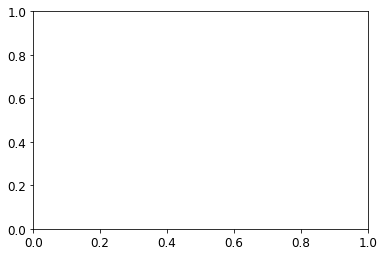

In [880]:
%matplotlib inline
plt.plot(range(0, len(filelist)), pca.explained_variance_ratio_)
plt.xlim(0, 10)

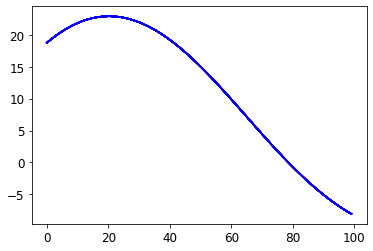

In [894]:
%matplotlib inline

for i_dir in range(6):
    plt.plot(projection[0:100, 0], 'r')
    plt.plot(projection[100:200, 0], 'r')
    plt.plot(projection[200:300, 0], 'r')
    plt.plot(projection[300:400, 0], 'r')
    
for i_dir in range(6, 12):
    plt.plot(projection[600:700, 0], 'b')
    plt.plot(projection[700:800, 0], 'b')
    plt.plot(projection[800:900, 0], 'b')

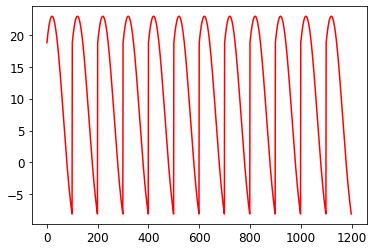

In [893]:
%matplotlib inline

for i_dir in range(6):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], 'r')

    
for i_dir in range(6, 12):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], 'b')

#plt.ylim(50, 70)

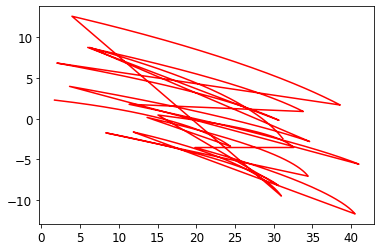

In [875]:
%matplotlib inline

for i_dir in range(6):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 1], 'r')
    
for i_dir in range(6, 12):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 1], 'b')



<IPython.core.display.Javascript object>


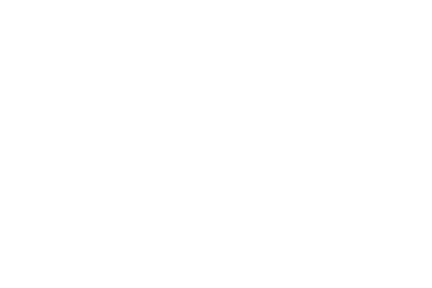

Text(0.5, 0, 'PC1')

<IPython.core.display.Javascript object>


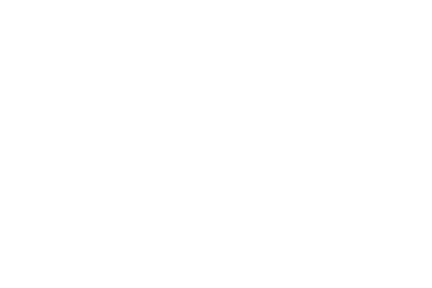

In [878]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

for i_dir in range(3):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category1'])

for i_dir in range(3, 6):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category1'])
        
for i_dir in range(6, 9):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category2'])

for i_dir in range(9, 12):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category2'])

ax.set_xlabel('PC1')

<IPython.core.display.Javascript object>


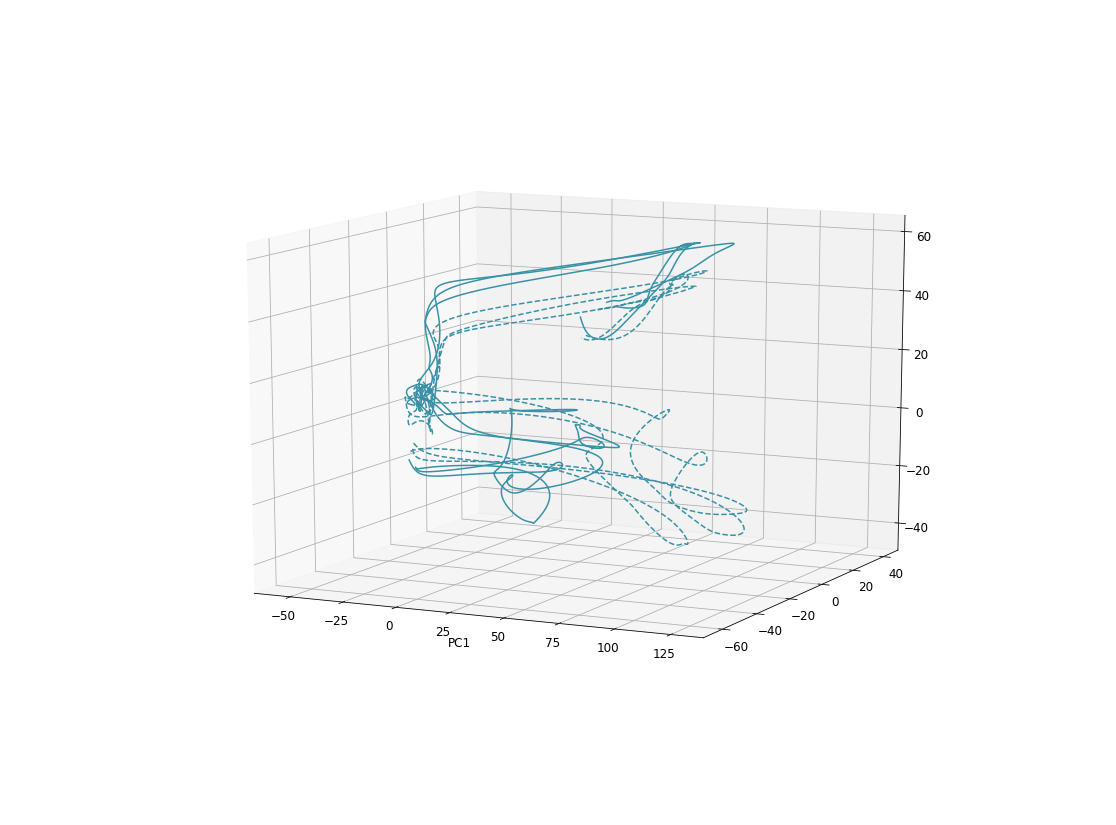

Text(0.5, 0, 'PC1')

In [385]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

for i_dir in range(3):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category1'])

for i_dir in range(3, 6):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category1'])
ax.set_xlabel('PC1')        

<IPython.core.display.Javascript object>


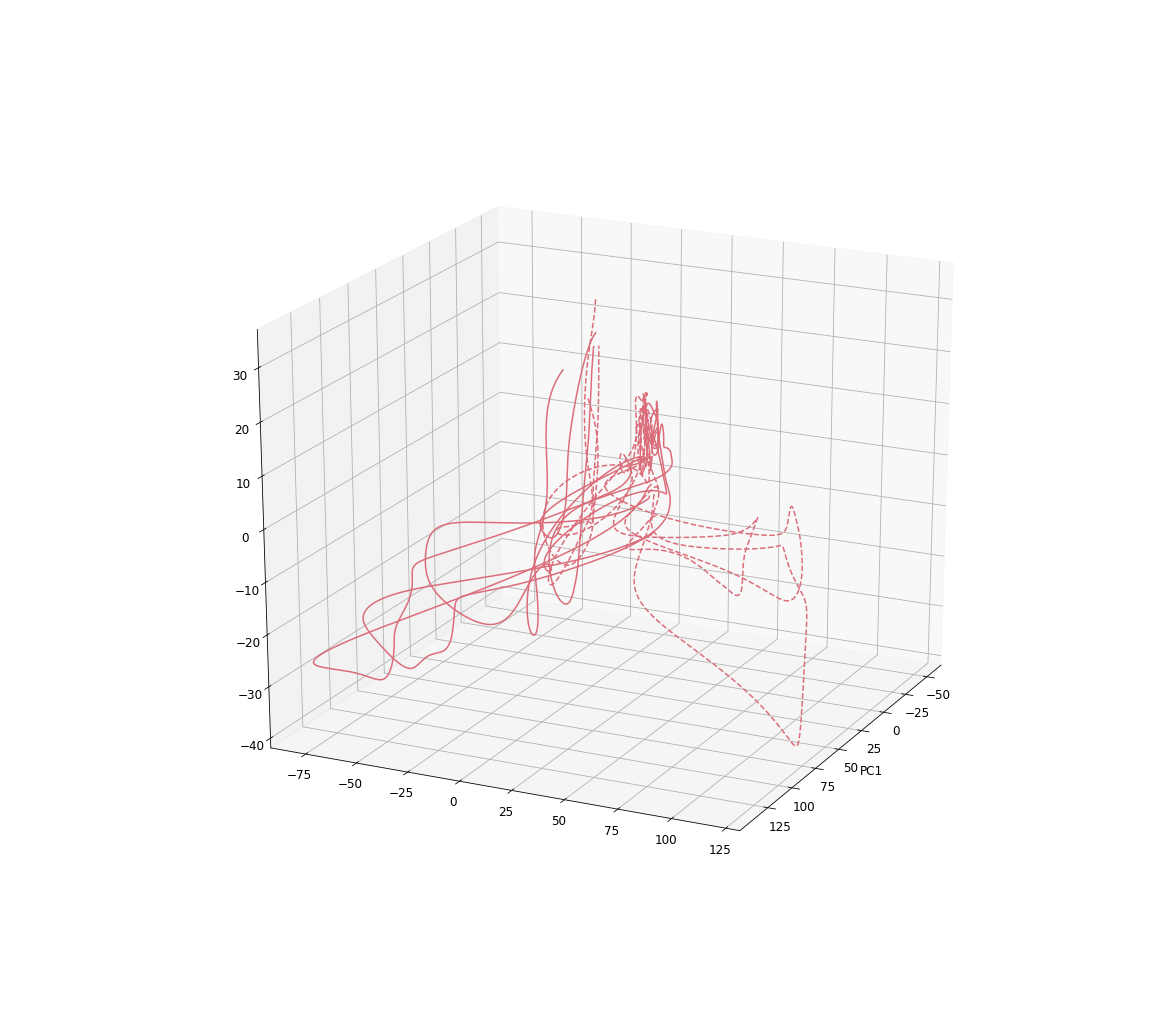

Text(0.5, 0, 'PC1')

In [387]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')


for i_dir in range(6, 9):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], '--', color = plot_colors['Category2'])

for i_dir in range(9, 12):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], plot_colors['Category2'])

ax.set_xlabel('PC1')        

In [254]:
tp = np.arange(np.where(bins == DELAY1-100)[0][0], np.where(bins == TEST1)[0][0])

cat1_45 = [2,8,15,20,26,31,40,42,46,48,52,54,58,60,64,66,70,72]
cat1_225 = [1,7,13,20,26,32,39,41,45,47,51,53,57,59,63,65,69,71]
cat2_135 = [3,5,9,11,15,17,22,24,28,30,34,36,37,43,49,56,62,68]
cat2_315 = [4,6,10,12,16,18,21,23,27,29,33,35,38,44,50,55,61,67]


In [319]:
rCTI_sliding_window_all = {}
rCTI_mean = {}
rCTI_std = {}

for area in brain_areas[0:1]: 
    currpath = datapathsave + monkey + '\\' + area + '\\good_neurons\\task_responsive\\'

    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]
    n_files = len(filelist)

    rCTI_all = [[] for i in range(n_files)]

    for i, file in enumerate(filelist[67:69]):
        data = sio.loadmat(file)['raw_spikes'][0]*1000
        
        cat1_1_sample1 = np.vstack([data[i-1] for i in cat1_45 if len(data[i-1]) > 0 and i <= 36])
        cat1_2_sample1 = np.vstack([data[i-1] for i in cat1_225 if len(data[i-1]) > 0 and i <= 36])
        cat1_1_sample2 = np.vstack([data[i-1] for i in cat1_45 if len(data[i-1]) > 0 and i > 37])
        cat1_2_sample2 = np.vstack([data[i-1] for i in cat1_225 if len(data[i-1]) > 0 and i > 37])
        
        cat2_1_sample2 = np.vstack([data[i-1] for i in cat2_135 if len(data[i-1]) > 0 and i > 37])
        cat2_2_sample2 = np.vstack([data[i-1] for i in cat2_315 if len(data[i-1]) > 0 and i > 37])
        cat2_1_sample1 = np.vstack([data[i-1] for i in cat2_135 if len(data[i-1]) > 0 and i <= 36])
        cat2_2_sample1 = np.vstack([data[i-1] for i in cat2_315 if len(data[i-1]) > 0 and i <= 36])

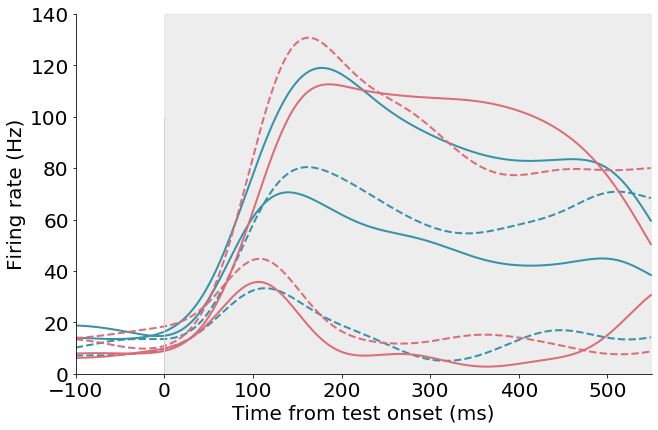

In [325]:
%matplotlib inline
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([1,1,1,1])
    
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat1_1_sample1, 0), sm_std)[tp], color = plot_colors['Category1'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat1_2_sample1, 0), sm_std)[tp], color = plot_colors['Category1'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat1_1_sample2, 0), sm_std)[tp], '--', color = plot_colors['Category1'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat1_2_sample2, 0), sm_std)[tp], '--', color = plot_colors['Category1'], lw = 2)

ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat2_1_sample2, 0), sm_std)[tp], color = plot_colors['Category2'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat2_2_sample2, 0), sm_std)[tp], color = plot_colors['Category2'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat2_1_sample1, 0), sm_std)[tp], '--', color = plot_colors['Category2'], lw = 2)
ax.plot(range(-100, len(tp)-100), gaussian_filter1d(np.mean(cat2_2_sample1, 0), sm_std)[tp], '--', color = plot_colors['Category2'], lw = 2)

ax.plot([0, 0], [0, 100], 'lightgrey', lw = 1)

ax.set_xlabel('Time from test onset (ms)', fontsize = 20)
ax.set_ylabel('Firing rate (Hz)', fontsize = 20)

#ax.axvspan(0, TRIAL_EPOCHS[0], alpha = 0.4, color = 'lightgrey', zorder=1)
ax.axvspan(0, 550, alpha = 0.4, color = 'lightgrey', zorder=2)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

plt.xlim((-100, 550))
plt.ylim((0, 140))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)


In [318]:
filelist[68]

'20200424_1_SPK12a.mat'